In [1]:
import trimesh
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

import os
import torch
from model import PointNetCls, PointNetDenseCls
from dataloader import points_dataloader
from torch.utils.data import DataLoader
import torch.nn as nn
from torch import optim

In [2]:
torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
t = torch.rand(1,2).to(device)
t

tensor([[0.3304, 0.0418]])

In [3]:
def accuracy(dataloader, model):
    y_pred = []
    y_true = []
    device = 'cpu'
    if list(model.parameters())[0][0].is_cuda:
        device = 'cuda'
    for i in dataloader:
        inpt = i['inpt'].to(device)
        labels = i['label'].view(-1)
        predict = model(inpt)[0]
        n_cls = pred.shape[-1]
        argmax = predict.view(-1,n_cls).argmax(axis=1).detach().cpu().tolist()
        y_pred = y_pred + argmax
        y_true = y_true + labels.detach().cpu().tolist()
        assert len(y_pred) == len(y_true),'Размеры не совпадают'
    return accuracy_score(y_true, y_pred)

In [4]:
dir_path = 'dataset 3/'
files = os.listdir(dir_path)

NUM_EPOCHS = 500
BATCH_S    = 16
N_CLASS    = 2

In [5]:
model = PointNetCls(N_CLASS).to(device)
# model = PointNetDenseCls(N_CLASS).to(device)

In [9]:
data = points_dataloader(dir_path, True, True)
train_loader = DataLoader(data, BATCH_S)

test_data = points_dataloader(dir_path, False, True)
test_loader = DataLoader(test_data, BATCH_S)

Количество примеров:  200   200
Количество примеров:  100   100


In [11]:
i.shape

torch.Size([16, 3, 500])

In [14]:
s = next(iter(test_loader))
i = s['inpt'].to(device)
print(i.shape)
t = s['label']
pred = model(i)[0]
# pred = pred.view(-1, 5)
print(pred.shape, t.shape)


torch.Size([16, 3, 500])
torch.Size([16, 2]) torch.Size([16])


In [15]:
i

tensor([[[-2.1211e-01, -9.5902e-02,  6.8921e-01,  ..., -4.8826e-01,
          -1.7341e-01,  4.8737e-01],
         [ 5.1348e-01, -8.5143e-01, -4.0745e-01,  ...,  5.3364e-01,
           9.5539e-01, -6.7917e-01],
         [ 7.1978e-01,  4.0901e-01,  5.6740e-01,  ...,  1.6063e-01,
          -3.0016e-01,  7.5179e-01]],

        [[-3.2302e-02,  8.0430e-01,  8.7915e-01,  ..., -8.3801e-01,
           5.9319e-01, -6.0907e-01],
         [ 8.6020e-01,  8.6995e-01, -7.4003e-01,  ...,  6.9619e-01,
          -7.2364e-01, -8.6846e-01],
         [ 7.5627e-01,  8.8191e-02,  3.2180e-01,  ...,  4.5744e-01,
           8.5105e-01,  2.7166e-01]],

        [[ 5.7153e-01,  9.2394e-02, -4.1238e-01,  ..., -4.1117e-01,
          -3.0516e-01, -4.6548e-01],
         [ 1.4385e-01, -4.5079e-01,  4.1493e-01,  ..., -1.8164e-01,
          -1.6980e-02, -4.8810e-01],
         [-4.1578e-02, -3.0567e-02, -2.7400e-01,  ...,  1.6882e-01,
           4.1122e-01, -1.7310e-01]],

        ...,

        [[-4.3704e-01, -2.8305e-01,

In [110]:
s = next(iter(test_loader))
i = s['inpt']
t = s['label']
t.shape

torch.Size([16, 500])

Обучение сети

In [111]:
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

In [112]:
loss_history = []
acc_history  = []
acc = -1
NLL_loss = nn.NLLLoss(reduce='sum')
for e in range(NUM_EPOCHS):
#     scheduler.step()
    for i in train_loader:
        inpt = i['inpt'].to(device)
        target = i['label'].to(device)
        pred = model(inpt)
        optimizer.zero_grad()
        pred, trans, trans_feat = model(inpt)
        batch_s = pred.shape[0]
        loss = NLL_loss(pred.view(batch_s*500,N_CLASS), target.view(-1))
        loss.backward()
        optimizer.step()
    loss_history.append(loss.item())
    if e % 5 == 0:
        acc = accuracy(test_loader, model)
        acc_history.append(acc)
        print('E:',e,'Loss: ',loss.item(), 'acc:',acc)
        continue
#     print('E:',e,'Loss: ',loss.item())

/home/kirill/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


E: 0 Loss:  1.007851481437683 acc: 0.41506
E: 5 Loss:  0.4405931532382965 acc: 0.91398
E: 10 Loss:  0.3468400239944458 acc: 0.9402


KeyboardInterrupt: 

In [113]:
accuracy(test_loader, model)

0.86158

In [212]:
torch.save(model.state_dict(),'model_seg.pt')

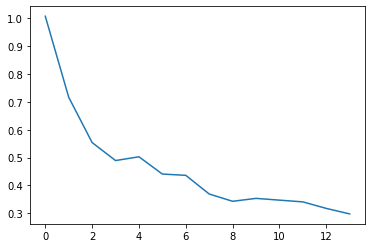

In [114]:
plt.plot(loss_history)

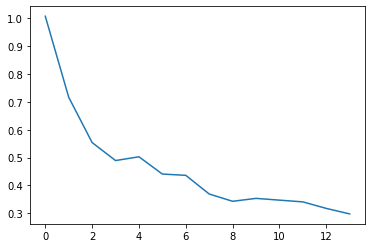

In [115]:
plt.plot(loss_history)

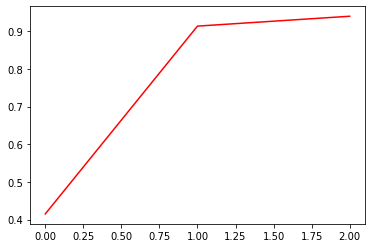

In [116]:
plt.plot(acc_history,'red')

In [127]:
s = 0
for inpt in train_loader:
#     print(i['label'])
    i = inpt['inpt'].to(device)
    label = inpt['label'].to(device)
    pred, _, _ = model(i)
    s+=(pred.argmax(axis=1) == label).sum().item()

In [128]:
len(train_loader)*10 - s

28

In [129]:
accuracy(test_loader, model)

0.5

In [130]:
a = classification_report(y_pred, y_true)

NameError: name 'y_pred' is not defined

In [138]:
d =torch.load('model_851.pt',map_location=torch.device('cpu'))
model = PointNetCls(6)
model.load_state_dict(d)

<All keys matched successfully>

In [139]:
mesh = trimesh.load_mesh('scene.ply')
points = np.array(mesh.vertices)
points.mean(axis=0)
points.shape

(6540, 3)

In [159]:
mesh = trimesh.load_mesh('scene.ply')
points = np.array(mesh.vertices)
mean = points.mean(axis=0)
points = points - np.expand_dims(mean,0)
scale  = (points**2).sum(axis=1).max()
# points = points/scale
print(points.mean(axis=0))
points = torch.tensor(points, dtype=torch.float).T.unsqueeze(0)
N = points.shape[2]
points = points.reshape(2,3,int(N/2)).to(device)

[-2.96353156e-15 -5.14680890e-15  1.46234027e-14]


In [160]:
points.shape

torch.Size([2, 3, 3270])

In [161]:
pred_cls = model(points.T)[0]
pred_cls.shape

torch.Size([3270, 6])

In [162]:
arg = pred_cls.argmax(axis=1)

In [163]:
arg.shape

torch.Size([3270])

No handles with labels found to put in legend.


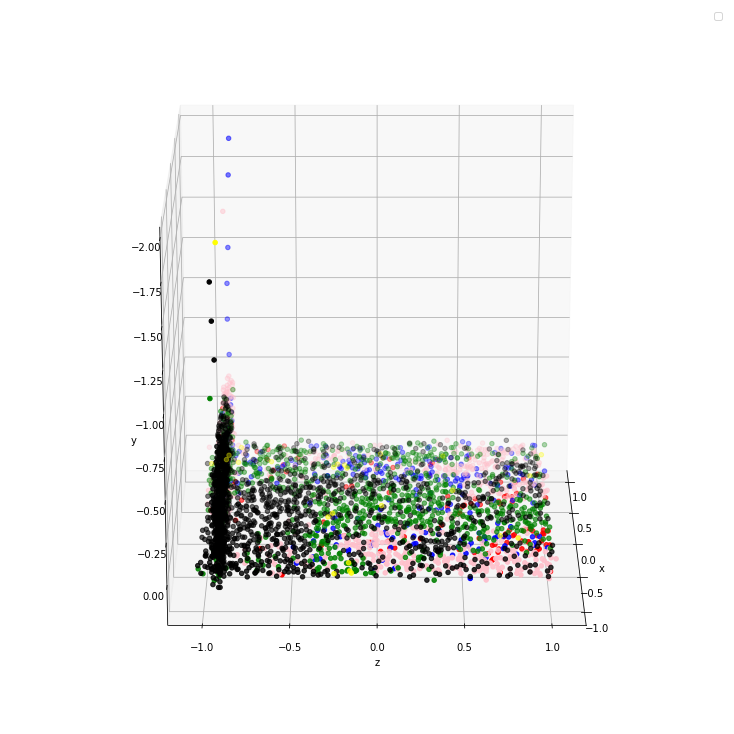

In [164]:
plot_points(mesh,arg.view(-1).detach().cpu().numpy() , 200, -0)

In [157]:
def plot_points(mesh, colors = None, fx = 0, fy = 0):
    x = []
    y = []
    z = []
    if isinstance(mesh,np.ndarray):
        x = mesh.T[0]
        y = mesh.T[1]
        z = mesh.T[2]
    else:
        for m in mesh.vertices:
            x.append(m[0])
            y.append(m[1])
            z.append(m[2])
        x = np.array(x)
        y = np.array(y)
        z = np.array(z)
        
        
    fig = plt.figure(figsize=(10, 10))
    ax = Axes3D(fig)
    colors_dict = {0:'red',1:'blue',2:'green',3:'yellow',4:'black', 5:'pink'}
    for c in np.unique(colors):
        indexs = np.where(colors == c)[0]
        if len(indexs)>0:
            ax.scatter3D(x[indexs], z[indexs], -y[indexs], color = colors_dict[c] )
    
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.scatter3D(x[0], z[0], -y[0], c = 'red')
    ax.scatter3D(0,0,0, c='green')
    ax.legend()
    ax.view_init(fx, fy)
    plt.show()


In [158]:
pnts = np.array(mesh.vertices)
n = len(pnts)
radius = np.zeros((n,n))
for i,p1 in enumerate(pnts):
    r = np.sqrt(((pnts - p1)**2).sum(axis=1))
    radius[i,:] = r

(-1, 1)

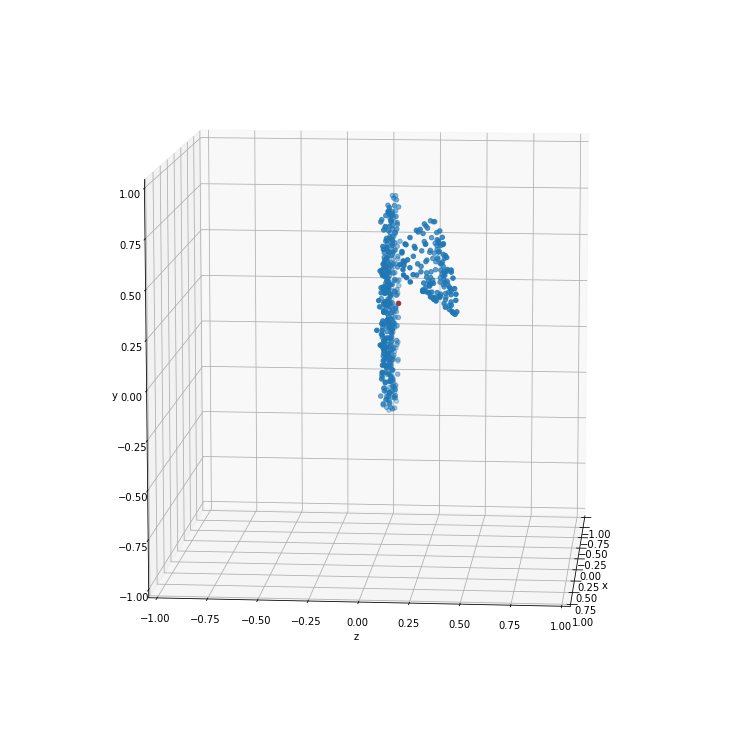

In [86]:
n = 8
t = radius[n]
pnts[n]
index = np.argsort(t)[:500]
index.shape
fig = plt.figure(figsize=(10, 10))
ax = Axes3D(fig)
colors_dict = {0:'red',1:'blue',2:'green',3:'yellow',4:'black', 5:'pink'}
ax.scatter3D(pnts[index,0], pnts[index,1], pnts[index,2])
ax.scatter3D(pnts[n][0],pnts[n][1],pnts[n][2], color = 'red')
ax.set_xlabel('x')
ax.set_ylabel('z')
ax.set_zlabel('y')
ax.view_init(10, 5)
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)


In [204]:
d =torch.load('model_85.pt',map_location=torch.device('cpu'))
model = PointNetCls(6)
model.load_state_dict(d)

<All keys matched successfully>

In [270]:
test_data = points_dataloader('dataset', False, True)
test_loader = DataLoader(test_data, BATCH_S, shuffle=False)

Количество примеров:  420   420


In [271]:
y_pred = []
y_true = []
device = 'cpu'
if list(model.parameters())[0][0].is_cuda:
    device = 'cuda'
for i in test_loader:
    inpt = i['inpt'].to(device)
    labels = i['label'].view(-1)
    predict = model(inpt)[0]
    n_cls = pred.shape[-1]
    print(pred.shape)
    argmax = predict.view(-1,n_cls).argmax(axis=1).detach().cpu().tolist()
    y_pred = y_pred + argmax
    y_true = y_true + labels.detach().cpu().tolist()
    print(len(y_true), len(y_pred))
    assert len(y_pred) == len(y_true),'Размеры не совпадают'

torch.Size([8, 2])
16 48


AssertionError: Размеры не совпадают

In [303]:
model = model.eval()

In [311]:
k = 0
for i in test_loader:
    inpt = i['inpt'].to(device)
    labels = i['label'].view(-1)
    print(inpt[0][0][0], labels[0])
    k+=1
print(k)
print(inpt,labels)
y = model(inpt)[0]
y.argmax(axis=1)

tensor(-0.2546) tensor(1)
tensor(0.1127) tensor(1)
tensor(-0.4422) tensor(1)
tensor(-0.0078) tensor(1)
tensor(0.2634) tensor(0)
tensor(0.0796) tensor(0)
tensor(-0.2290) tensor(0)
tensor(-0.1874) tensor(2)
tensor(-0.2418) tensor(2)
tensor(0.4799) tensor(2)
tensor(0.3797) tensor(5)
tensor(0.1055) tensor(5)
tensor(0.6798) tensor(5)
tensor(0.1637) tensor(3)
tensor(0.0810) tensor(3)
tensor(-0.2753) tensor(3)
tensor(0.1586) tensor(4)
tensor(-0.0071) tensor(4)
tensor(-0.0325) tensor(4)
tensor(-0.0799) tensor(4)
tensor(-0.1120) tensor(4)
tensor(0.2441) tensor(4)
tensor(0.1053) tensor(4)
tensor(0.0060) tensor(4)
tensor(0.0820) tensor(4)
tensor(-0.1177) tensor(4)
tensor(-0.0476) tensor(4)
27
tensor([[[-0.0476,  0.1640, -0.0582,  ..., -0.2355, -0.0604,  0.1547],
         [-0.0661,  0.1047,  0.2102,  ...,  0.2954,  0.3108, -0.2243],
         [-0.2232,  0.3447, -0.2109,  ..., -0.1438,  0.2708, -0.1630]],

        [[ 0.2276,  0.1602,  0.0399,  ...,  0.1595,  0.0626,  0.1242],
         [ 0.2376,  0.2

tensor([4, 4, 5, 3])

In [221]:
labels

tensor([0, 0, 0, 0])